In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
from sklearn.model_selection import KFold
import itertools
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.kalman import MerweScaledSigmaPoints

In [103]:
file_path = './Synched_Data_GR0_22_DEN_MAXZ1_25/NEWDATA/'
file_date = ['101922', '102122', '111422', '111622', '120522', '120722', '013023', '020123', '031323', '031523', '041723', '041923', '061523']
date = file_date[0]

file_name = f'DAYUBIGR_{date}_GR0_22_DEN_032825_V2392628911.CSV'
full_path = file_path + file_name

raw_data = pd.read_csv(full_path, header=None, names=['SUBJECTID', 'TIME', 'X', 'Y', 'Z'])
clear_data = raw_data.reset_index(drop=True)
clear_data = clear_data[(clear_data["X"] <= 15) & (clear_data["Y"] <= 9) & 
                        (clear_data["X"] >= 0) & (clear_data["Y"] >= 0)].copy()
target_subject_base = "DS_STARFISH_2223_27"
subject_data = clear_data[clear_data['SUBJECTID'].str.startswith(target_subject_base)].copy()
subject_data['TIME'] = pd.to_datetime(subject_data['TIME'])
t0 = subject_data['TIME'].min()
subject_data['timestamp'] = (subject_data['TIME'] - t0).dt.total_seconds()

subject_data['side'] = subject_data['SUBJECTID'].str.extract(r'(\d+[LR])$')[0].str[-1].map({'L': 'left', 'R': 'right'})
subject_data['timestamp_rounded'] = subject_data['timestamp'].round(3)

grouped = subject_data.groupby('timestamp_rounded')
real_data = []

for ts, group in grouped:
    entry = {'timestamp': ts}
    left = group[group['side'] == 'left']
    right = group[group['side'] == 'right']
    
    if not left.empty:
        left_xy = left[['X', 'Y']].iloc[0].to_numpy()
        entry['left'] = left_xy
    if not right.empty:
        right_xy = right[['X', 'Y']].iloc[0].to_numpy()
        entry['right'] = right_xy
    
    if 'left' in entry and 'right' in entry:
        entry['observed'] = 'both'
        entry['obs'] = np.concatenate([entry['left'], entry['right']])
    elif 'left' in entry:
        entry['observed'] = 'left'
        entry['obs'] = entry['left']
    elif 'right' in entry:
        entry['observed'] = 'right'
        entry['obs'] = entry['right']
    else:
        entry['observed'] = 'none'
        entry['obs'] = np.array([])

    real_data.append(entry)

In [104]:
DT_VIRT = 0.5  # Virtual time step interval
SIGMA_MIN = 0.000001
SIGMA_MAX = 10
sigma_v_values = [0.01, 0.05, 0.1, 0.5]
sigma_omega_values = [0.001, 0.01, 0.05, 0.1]
sigma_obs_values = [0.5, 1]
param_combinations = list(itertools.product(sigma_v_values, sigma_omega_values, sigma_obs_values))
results = []

In [105]:
def state_transition(state, dt, sigma_vx, sigma_vy, sigma_omega):
    x, y, theta, vx, vy, omega = state
    return np.array([
        x + vx * dt,
        y + vy * dt,
        theta + omega * dt,
        vx,
        vy,
        omega
    ])

def measurement_function(state, observed_sensors='both', d = 0.23):
    x, y, theta = state[0], state[1], state[2]
    
    if observed_sensors == 'both':
        # Return [Lx, Ly, Rx, Ry]
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta),
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    elif observed_sensors == 'left':
        return np.array([
            x - d * np.sin(theta),
            y + d * np.cos(theta)
        ])
    elif observed_sensors == 'right':
        return np.array([
            x + d * np.sin(theta),
            y - d * np.cos(theta)
        ])
    else:  # 'none'
        return np.array([])

def create_ukf(initial_state, initial_P, sigma_vx, sigma_vy, sigma_omega, sigma_obs, d):
    points = MerweScaledSigmaPoints(n=6, alpha=0.001, beta=2., kappa=0)
    ukf = UnscentedKalmanFilter(dim_x=6, dim_z=4, dt=DT_VIRT, 
                               hx=lambda x: measurement_function(x, 'both', d),
                               fx=lambda x, dt: state_transition(x, dt, sigma_vx, sigma_vy, sigma_omega),
                               points=points)
    
    # Set initial state and covariance
    ukf.x = initial_state.copy()
    ukf.P = initial_P.copy()
    
    return ukf

In [106]:
def ukf_forward(data, timestamps, virtual_timestamps, params):
    sigma_vx, sigma_vy, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    initial_state = np.zeros(6)
    for entry in data[:10]:
        if entry['observed'] != 'none':
            if entry['observed'] == 'left':
                initial_state[:2] = entry['left']
                break
            elif entry['observed'] == 'right':
                initial_state[:2] = entry['right']
                break
            elif entry['observed'] == 'both':
                initial_state[:2] = (entry['left'] + entry['right']) / 2
                break
    
    initial_P = np.diag([1, 1, 1, 1, 1, 0.1])
    
    ukf = create_ukf(initial_state, initial_P, sigma_vx, sigma_vy, sigma_omega, sigma_obs, d)
    
    states_pred = []
    states_filt = []
    covariances_pred = []
    covariances_filt = []
    neg_log_likelihood = 0.0
    
    for k in range(T):
        t_k = master_timestamps[k]
        
        if k > 0:
            dt = t_k - master_timestamps[k-1]
            
            # Update transition function with current dt
            ukf.fx = lambda x, dt=dt: state_transition(x, dt, sigma_vx, sigma_vy, sigma_omega)
            
            ukf.Q = block_diag(0, 0, 0, sigma_vx**2 * dt, sigma_vy**2 * dt, sigma_omega**2 * dt)
            
            ukf.predict(dt=dt)
        
        states_pred.append(ukf.x.copy())
        covariances_pred.append(ukf.P.copy())
        
        # Update step
        if t_k in timestamps:
            idx = timestamps.index(t_k)
            observed_sensors = data[idx]['observed']
            
            if observed_sensors != 'none':
                # Set measurement function for current observation type
                ukf.hx = lambda x: measurement_function(x, observed_sensors, d)
                
                # Get observation
                z = data[idx]['obs']
                m_t = len(z)
                
                # Set measurement noise
                ukf.R = sigma_obs**2 * np.eye(m_t)
                
                try:
                    # Predict measurement
                    z_pred = ukf.hx(ukf.x)
                    
                    # Calculate innovation for likelihood
                    innovation = z - z_pred
                    
                    # Get innovation covariance (S matrix)
                    # For UKF, we need to compute this manually or approximate
                    H_approx = np.zeros((m_t, 6))  # Approximate Jacobian for S calculation
                    epsilon = 1e-6
                    for i in range(6):
                        x_plus = ukf.x.copy()
                        x_minus = ukf.x.copy()
                        x_plus[i] += epsilon
                        x_minus[i] -= epsilon
                        h_plus = measurement_function(x_plus, observed_sensors, d)
                        h_minus = measurement_function(x_minus, observed_sensors, d)
                        H_approx[:, i] = (h_plus - h_minus) / (2 * epsilon)
                    
                    S = H_approx @ ukf.P @ H_approx.T + ukf.R
                    S = (S + S.T) / 2  # Ensure symmetry
                    
                    # Calculate log likelihood contribution
                    sign, logdet = np.linalg.slogdet(S)
                    if sign > 0:
                        neg_log_likelihood += 0.5 * (m_t * np.log(2 * np.pi) + logdet + innovation @ np.linalg.inv(S) @ innovation)
                    
                    # Perform update
                    ukf.update(z)
                    
                except Exception as e:
                    print(f"Update failed: {e}")
                    # Skip update if it fails
                    pass
        
        # Store filtered state and covariance
        states_filt.append(ukf.x.copy())
        covariances_filt.append(ukf.P.copy())
    
    return states_filt, covariances_filt, states_pred, covariances_pred, neg_log_likelihood

In [107]:
def ukf_smoother(states_filt, covariances_filt, states_pred, covariances_pred, timestamps, virtual_timestamps, params):
    sigma_vx, sigma_vy, sigma_omega, sigma_obs, d = params
    master_timestamps = sorted(set(timestamps + virtual_timestamps))
    T = len(master_timestamps)
    
    states_smooth = [s.copy() for s in states_filt]
    covariances_smooth = [P.copy() for P in covariances_filt]
    
    # Backward pass
    for k in range(T - 2, -1, -1):
        dt = master_timestamps[k + 1] - master_timestamps[k]
        
        F = np.array([
            [1, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, dt],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1]
        ])
        
        try:
            # Smoother gain
            C = covariances_filt[k] @ F.T @ np.linalg.inv(covariances_pred[k + 1])
            
            # Smooth state and covariance
            states_smooth[k] = states_filt[k] + C @ (states_smooth[k + 1] - states_pred[k + 1])
            covariances_smooth[k] = (covariances_filt[k] + 
                                   C @ (covariances_smooth[k + 1] - covariances_pred[k + 1]) @ C.T)
        except np.linalg.LinAlgError:
            # Fall back to filtered estimates
            states_smooth[k] = states_filt[k]
            covariances_smooth[k] = covariances_filt[k]
    
    return states_smooth, covariances_smooth

def optimize_parameters_ukf(data, timestamps, virtual_timestamps, initial_params=None):
    bounds = [
        (SIGMA_MIN, SIGMA_MAX),
        (SIGMA_MIN, SIGMA_MAX),
        (SIGMA_MIN, SIGMA_MAX),
        (0.01, SIGMA_MAX),
        (0.01, 1.0)
    ]
    
    def objective(params):
        try:
            _, _, _, _, neg_log_likelihood = ukf_forward(data, timestamps, virtual_timestamps, params)
            return neg_log_likelihood
        except Exception as e:
            print(f"Error in objective function: {e}")
            return np.inf
    
    result = minimize(
        objective,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'disp': True, 'maxiter': 50}
    )
    
    return result.x

4852.86596551764
[4514.634440606669, 4478.148074712361, 4412.023258967939, 4410.776742384167, 4425.234449054361, 4363.530240671003, 4351.648610622329, 4385.995557465328, 4352.257239043973, 4340.294214323414, 4322.777038042317, 4362.231231462036, 4306.812064850967, 4297.80533424565, 4301.966903218905, 4306.681289213316, 4313.278529962826, 4333.287380734108, 4390.195654577641, 4372.438995916047, 4367.213644049159, 4403.340233995392, 4405.170058108582, 4422.590899103467, 4476.779065140574, 4421.26877929954, 4427.671273725253, 4433.235988073693, 4449.455266137605, 4470.956829124181, 4479.027407455201, 4480.568522316427, 4487.386223582459, 4496.943436614697, 4512.921100464003, 4535.41086933818, 4544.909184169646, 4560.100889969925, 4526.149658727673, 4547.761371606398]


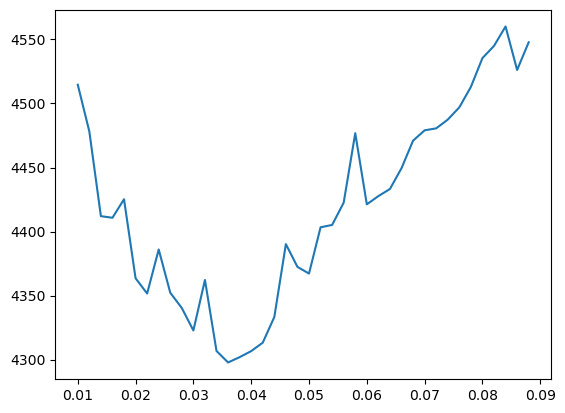

In [108]:
timestamps = [entry['timestamp'] for entry in real_data][:3000]

virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
opt_param = np.asarray([0.1618797953673447, 0.1468003718561886, 0.0687631980898424, 0.447965246728742, 0.4145066884413448])
s_filt, P_filt, s_hat, P, neg_log_likelihood = ukf_forward(real_data[:3000], timestamps, virtual_timestamps, opt_param)
print(neg_log_likelihood)
sigma_1_array = np.arange(0.01, 0.09, 0.002)
all_nll = []
for idx, sigma_1 in enumerate(sigma_1_array):
    this_param = opt_param.copy()
    this_param[0] = sigma_1
    this_param[1] = sigma_1
    s_filt, P_filt, s_hat, P, neg_log_likelihood = ukf_forward(real_data[:3000], timestamps, virtual_timestamps, this_param)
    all_nll.append(neg_log_likelihood)
print(all_nll)
plt.plot(sigma_1_array, all_nll)
plt.show()


Test 1
sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 0.5
Optimized params: [0.02274938 0.05021034 0.00089627 0.46901413 0.25379499]
Negative log-likelihood: 4681.646791571971


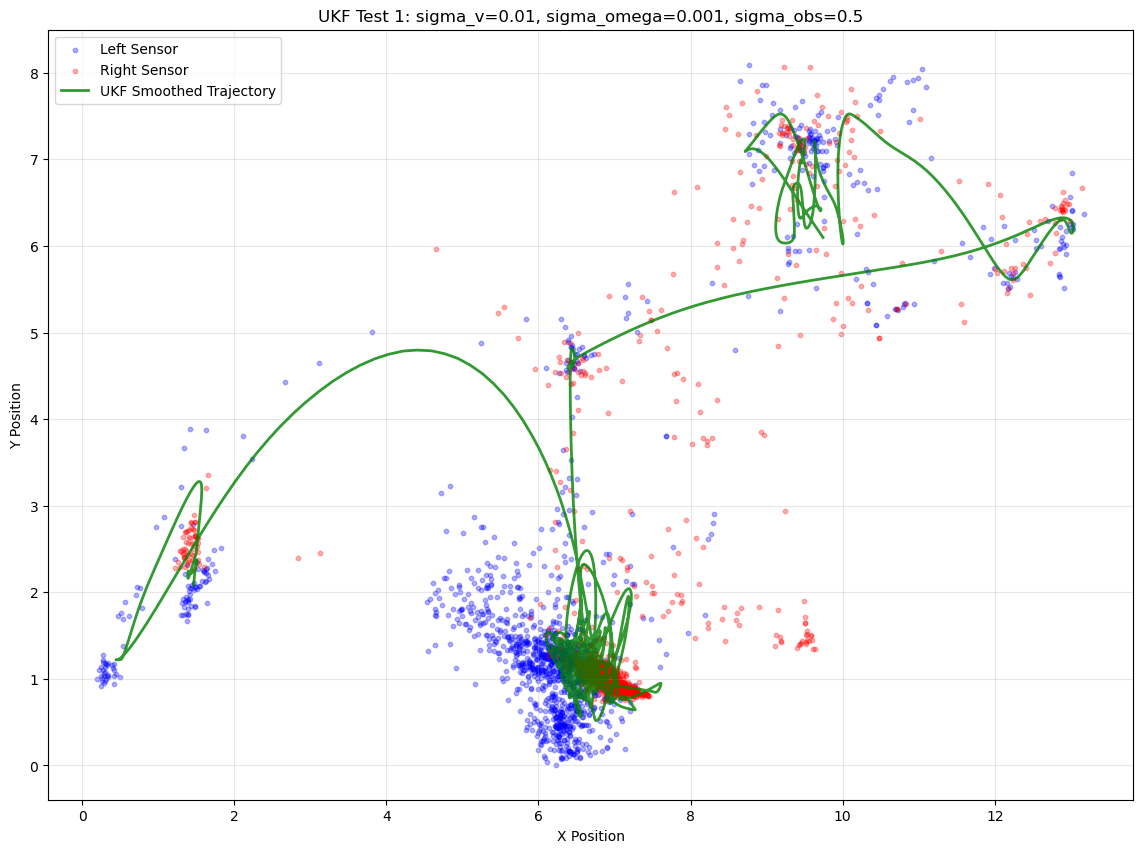


Test 2
sigma_v: 0.01, sigma_omega: 0.001, sigma_obs: 1


In [ ]:
for i, (sigma_v, sigma_omega, sigma_obs) in enumerate(param_combinations):
    print(f"\nTest {i+1}")
    print(f"sigma_v: {sigma_v}, sigma_omega: {sigma_omega}, sigma_obs: {sigma_obs}")
    
    try:
        initial_params = [sigma_v, sigma_v, sigma_omega, sigma_obs, 0.23]
        max_data_points = 3000
        data_subset = real_data[:max_data_points]
        timestamps = [entry['timestamp'] for entry in data_subset]
        virtual_timestamps = np.arange(min(timestamps), max(timestamps), DT_VIRT).tolist()
        
        optimized_params = optimize_parameters_ukf(data_subset, timestamps, virtual_timestamps, initial_params)
        
        states_filt, covariances_filt, states_pred, covariances_pred, neg_log_likelihood = ukf_forward(data_subset, timestamps, virtual_timestamps, optimized_params)
        
        states_smooth, covariances_smooth = ukf_smoother(states_filt, covariances_filt, states_pred, covariances_pred, timestamps, virtual_timestamps, optimized_params)
        
        result_dict = {
            'combination_id': i+1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'optimized_sigma_vx': optimized_params[0],
            'optimized_sigma_vy': optimized_params[1],
            'optimized_sigma_omega': optimized_params[2],
            'optimized_sigma_obs': optimized_params[3],
            'optimized_d': optimized_params[4],
            'negative_log_likelihood': neg_log_likelihood,
            'optimization_success': True
        }
        results.append(result_dict)
        print(f"Optimized params: {optimized_params}")
        print(f"Negative log-likelihood: {neg_log_likelihood}")

        plt.figure(figsize=(14, 10))
        plt.title(f'UKF Test {i+1}: sigma_v={sigma_v}, sigma_omega={sigma_omega}, sigma_obs={sigma_obs}')
        
        left_x, left_y = [], []
        right_x, right_y = [], []
        
        for entry in data_subset:
            if 'left' in entry:
                left_x.append(entry['left'][0])
                left_y.append(entry['left'][1])
            if 'right' in entry:
                right_x.append(entry['right'][0])
                right_y.append(entry['right'][1])
        
        plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
        plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)
        plt.plot([s[0] for s in states_smooth], [s[1] for s in states_smooth], 'g-', alpha=0.8, linewidth=2, label='UKF Smoothed Trajectory')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.xlabel('X Position')
        plt.ylabel('Y Position')
        plt.show()

    except Exception as e:
        print(f"Error in UKF combination {i+1}: {str(e)}")
        result_dict = {
            'combination_id': i + 1,
            'initial_sigma_v': sigma_v,
            'initial_sigma_omega': sigma_omega,
            'initial_sigma_obs': sigma_obs,
            'optimized_sigma_vx': np.nan,
            'optimized_sigma_vy': np.nan,
            'optimized_sigma_omega': np.nan,
            'optimized_sigma_obs': np.nan,
            'optimized_d': np.nan,
            'negative_log_likelihood': np.inf,
            'optimization_success': False
        }
        results.append(result_dict)

# Save results
results_df = pd.DataFrame(results)
output_filename = f'ukf_parameter_optimization_results_101922_27_3000.csv'
results_df.to_csv(output_filename, index=False)

In [ ]:
output = pd.read_csv('ukf_parameter_optimization_results_101922_27_3000.csv')
if 'optimization_success' in output.columns:
    success_results = output[output['optimization_success'] != False]
else:
    print("none")


if len(success_results) > 0:
    best_idx = success_results['negative_log_likelihood'].idxmin()
    best_result = success_results.loc[best_idx]
    print("\nBest Result:")
#     print(best_result)
    print(f"Initial parameters: {best_result['initial_sigma_v']}, {best_result['initial_sigma_omega']}, "
          f"{best_result['initial_sigma_obs']}")
    print(f"Optimized parameters: {best_result['optimized_sigma_vx']}, {best_result['optimized_sigma_vy']}, "
          f"{best_result['optimized_sigma_omega']}, {best_result['optimized_sigma_obs']}, {best_result['optimized_d']}")
    print(f"Negative log-likelihood: {best_result['negative_log_likelihood']}")
    
    print("\nTop 5 Results:")
    top_results = success_results.nsmallest(5, 'negative_log_likelihood')
    for index, row in top_results.iterrows():
        print(f"Combination {row['combination_id']}: "
              f"vx={row['optimized_sigma_vx']}, vy={row['optimized_sigma_vy']}, "
              f"omega={row['optimized_sigma_omega']}, obs={row['optimized_sigma_obs']}, d={row['optimized_d']}, "
              f"NLL={row['negative_log_likelihood']}")


Best Result:
Initial parameters: 0.5, 0.1, 1.0
Optimized parameters: 0.1618797953673447, 0.1468003718561886, 0.0687631980898424, 0.447965246728742, 0.4145066884413448
Negative log-likelihood: 4257.196637877239

Top 5 Results:
Combination 32: vx=0.1618797953673447, vy=0.1468003718561886, omega=0.0687631980898424, obs=0.447965246728742, d=0.4145066884413448, NLL=4257.196637877239
Combination 29: vx=0.1662367397766246, vy=0.191968583850878, omega=0.0627786049697901, obs=0.420068359535456, d=0.3954967598933012, NLL=4261.205686578195
Combination 1: vx=0.1776490356311214, vy=0.2984047645884071, omega=0.1874807581716868, obs=0.3505680286780639, d=0.3999047339826639, NLL=4382.917079318889
Combination 21: vx=0.1414355959458773, vy=0.1314870427581891, omega=0.0260990028016892, obs=0.4352052410069417, d=0.3115584799416048, NLL=4411.048282708889
Combination 28: vx=0.1652868024984437, vy=0.136977572131656, omega=0.0301226783573431, obs=0.4345701936428199, d=0.2922709979233835, NLL=4411.34730894760

In [ ]:
best_sigma_vx = 0.1618797953673447
best_sigma_vy = 0.1468003718561886
best_sigma_omega = 0.0687631980898424
best_sigma_obs = 0.447965246728742
best_d = 0.4145066884413448
final_params = [best_sigma_vx, best_sigma_vy, best_sigma_omega, best_sigma_obs, best_d]


Time Segments Information:
Segment 1: 0.00s - 2273.57s | Duration: 2273.57s | Points: 3671
Segment 2: 2353.03s - 2625.59s | Duration: 272.56s | Points: 390
Segment 3: 2653.03s - 2688.04s | Duration: 35.01s | Points: 38
Segment 4: 2705.02s - 2713.03s | Duration: 8.01s | Points: 9
Segment 5: 2774.60s - 2799.03s | Duration: 24.43s | Points: 28
Segment 6: 2815.60s - 2836.04s | Duration: 20.43s | Points: 16
Segment 7: 2862.59s - 2865.59s | Duration: 3.00s | Points: 4
Segment 8: 2893.59s - 2895.59s | Duration: 2.00s | Points: 3
Segment 9: 2911.03s - 2923.03s | Duration: 12.00s | Points: 12
Segment 10: 2943.04s - 3508.60s | Duration: 565.56s | Points: 651
Segment 11: 3524.60s - 4374.62s | Duration: 850.02s | Points: 1604
Segment 12: 4395.61s - 4421.62s | Duration: 26.01s | Points: 25
Segment 13: 4438.62s - 4725.05s | Duration: 286.43s | Points: 451
Segment 14: 7416.68s - 7421.67s | Duration: 4.98s | Points: 6
Segment 15: 7448.10s - 7467.09s | Duration: 18.99s | Points: 7
Segment 16: 7492.10s

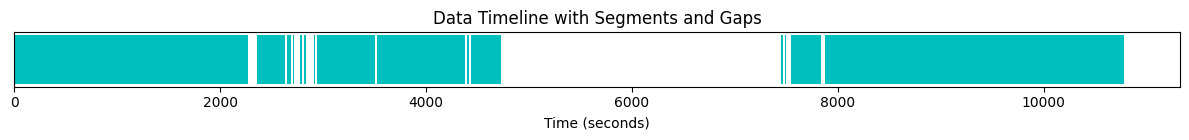

In [ ]:
df = pd.DataFrame(real_data)
df = df.sort_values('timestamp')
df['time_diff'] = df['timestamp'].diff()

gap_threshold = 15.0
gaps = df[df['time_diff'] > gap_threshold]

segments = []
current_segment_start = df['timestamp'].iloc[0]

for idx, row in gaps.iterrows():
    segment_end = row['timestamp'] - row['time_diff']
    
    # Count data points in this segment
    segment_data = df[(df['timestamp'] >= current_segment_start) & 
                      (df['timestamp'] <= segment_end)]
    num_points = len(segment_data)
    
    segments.append({
        'start': current_segment_start,
        'end': segment_end,
        'duration': segment_end - current_segment_start,
        'num_points': num_points
    })
    
    current_segment_start = row['timestamp']

# Add the last segment (with data point count)
segment_data = df[(df['timestamp'] >= current_segment_start) & 
                  (df['timestamp'] <= df['timestamp'].iloc[-1])]
num_points = len(segment_data)

segments.append({
    'start': current_segment_start,
    'end': df['timestamp'].iloc[-1],
    'duration': df['timestamp'].iloc[-1] - current_segment_start,
    'num_points': num_points  # <-- New field: number of data points
})

# Convert to DataFrame for better visualization
segments_df = pd.DataFrame(segments)

# Print segment info (now includes point counts)
print("\nTime Segments Information:")
for i, segment in enumerate(segments):
    print(
        f"Segment {i+1}: "
        f"{segment['start']:.2f}s - {segment['end']:.2f}s | "
        f"Duration: {segment['duration']:.2f}s | "
        f"Points: {segment['num_points']}"
    )

# Time gaps
plt.figure(figsize=(12, 1.5))
timeline_y = 1
timeline_height = 0.05

total_time = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
plt.barh(timeline_y, total_time, height=timeline_height, left=df['timestamp'].iloc[0], color='white')

# Plot each segment
for segment in segments:
    plt.barh(
        timeline_y, 
        segment['duration'], 
        height=timeline_height, 
        left=segment['start'], 
        color='c'
    )

plt.xlabel('Time (seconds)')
plt.yticks([])
plt.title(f'Data Timeline with Segments and Gaps')
plt.tight_layout()
plt.savefig(f'timeline_{target_subject_base}_{date}.png')
plt.show()

# Store the segments
time_segments = []
for segment in segments:
    segment_data = df[(df['timestamp'] >= segment['start']) & 
                      (df['timestamp'] <= segment['end'])].copy()
    time_segments.append({
        'start': segment['start'],
        'end': segment['end'],
        'duration': segment['duration'],
        'data': segment_data
    })


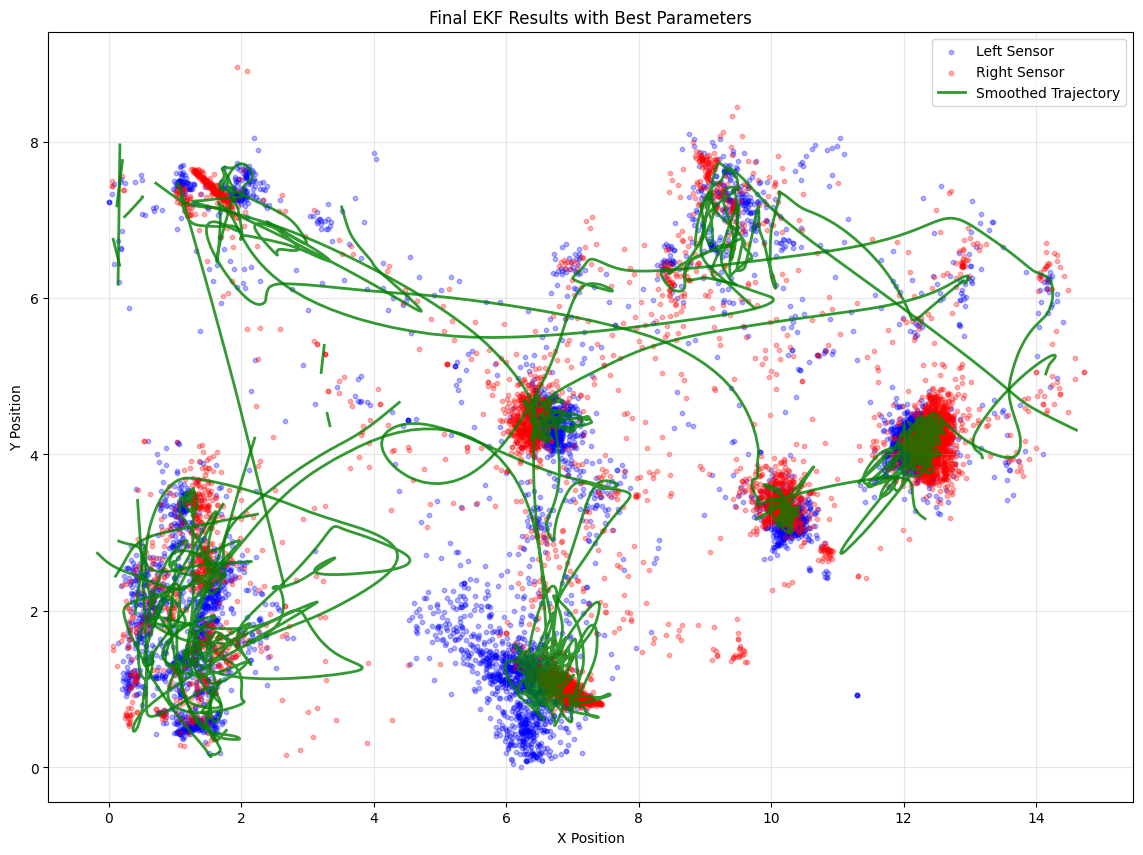

Final parameters used: [0.1618797953673447, 0.1468003718561886, 0.0687631980898424, 0.447965246728742, 0.4145066884413448]
Final negative log-likelihood: 5467.227644594504


In [ ]:
plt.figure(figsize=(14, 10))
plt.title('Final EKF Results with Best Parameters')

left_x, left_y = [], []
right_x, right_y = [], []
for entry in real_data:
    if 'left' in entry:
        left_x.append(entry['left'][0])
        left_y.append(entry['left'][1])
    if 'right' in entry:
        right_x.append(entry['right'][0])
        right_y.append(entry['right'][1])
plt.scatter(left_x, left_y, color='blue', alpha=0.3, label='Left Sensor', s=10)
plt.scatter(right_x, right_y, color='red', alpha=0.3, label='Right Sensor', s=10)

first = True  # Flag to only label the smoothed trajectory once
for time_segment in time_segments:
    run_data = time_segment['data'].to_dict(orient='records')

    final_s_filt, final_P_filt, final_s_hat, final_P, final_neg_log_likelihood = ukf_forward(
        run_data,
        [entry['timestamp'] for entry in run_data],
        np.arange(min(entry['timestamp'] for entry in run_data),
                  max(entry['timestamp'] for entry in run_data),
                  DT_VIRT).tolist(),
        final_params
    )

    final_s_smooth, final_P_smooth = ukf_smoother(
        final_s_filt, final_P_filt, final_s_hat, final_P,
        [entry['timestamp'] for entry in run_data],
        np.arange(min(entry['timestamp'] for entry in run_data),
                  max(entry['timestamp'] for entry in run_data),
                  DT_VIRT).tolist()
    )

    label = 'Smoothed Trajectory' if first else None
    first = False

    plt.plot(
        [s[0] for s in final_s_smooth],
        [s[1] for s in final_s_smooth],
        'g-', alpha=0.8, linewidth=2, label=label
    )

plt.grid(True, alpha=0.3)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

print(f"Final parameters used: {final_params}")
print(f"Final negative log-likelihood: {final_neg_log_likelihood}")


### video of left and right data see how it looks like
### the package of ukf
### double check the weight function
### swap backup numpy.linalg.eigh
### reduce the sigma range
### combine sigma vx and sigma vy and see if its still smooth